# Quickstart: オフ方策評価とオフ方策選択 (連続行動空間, 発展的内容)
このノートブックでは簡単な人工データセット上で **オフ方策学習(OPE)とオフ方策選択(OPS)** のより発展的な内容やその活用例を紹介します．

特に、以下の3つの順番で解説していきます: 
1. セットアップ，人工データの生成とオフライン強化学習
2. 様々なオフ方策評価 (方策価値推定，累積分布関数推定)
3. オフ方策選択

このライブラリは，オンラインとオフラインの方策学習およびモデルベースのオフ方策評価の一部で [d3rlpy](https://github.com/takuseno/d3rlpy)のアルゴリズムを利用しています．
また、実装のワークフローは[Open Bandit Pipeline](https://github.com/st-tech/zr-obp)を参考にしています．

In [3]:
# SCOPE-RL モジュールのインポート
import scope_rl
from basicgym import BasicEnv
from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import OnlineHead, ContinuousEvalHead
from scope_rl.policy import TruncatedGaussianHead
from scope_rl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# d3rlpy アルゴリズムのインポート
from d3rlpy.algos import RandomPolicy
from d3rlpy.preprocessing import MinMaxObservationScaler, MinMaxActionScaler

# その他のライブラリのインポート
import gym
import torch

In [4]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [5]:
# バージョン
print(scope_rl.__version__)

0.1.2


In [6]:
# random stateの設定
random_state = 12345

In [7]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [8]:
# logディレクトリ
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

In [9]:
# warnings
import warnings
warnings.simplefilter('ignore')

## 1. セットアップ，人工データ生成，オフライン強化学習
まず初めに，今回用いる簡単な環境設定について紹介します．

#### 強化学習での環境のセットアップ
今回は簡単なシミュレーション環境上で，方策の獲得する累積報酬を最大化する問題を考えます．

この強化学習の問題を(部分観測)マルコフ決定過程((PO)MDP)として定式化します．
- `状態`: 状態観測（POMDPの場合は観測ノイズが発生）．
- `行動`: 強化学習エージェント (方策) により選択された行動．
- `報酬`: 状態と行動に応じて観測される報酬．

より詳細に環境の引数を確認したい場合は，次のノートブックを参照してください．[examples/quickstart_ja/basic/basic_synthetic_customize_env_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/basic/basic_synthetic_customize_env_ja.ipynb)

In [10]:
# SCOPE-RLで実装されている連続行動空間に対する標準的な環境
env = gym.make("BasicEnv-continuous-v0")

#### 人工データ生成
オフ方策評価の目標は，過去に集められたデータを用いて新たな方策を評価することです．
そこで次のステップとして、データ収集方策$\pi_0$によりデータセットを収集します（今回はシミュレーション環境をオンライン環境とみなした人工データです）．

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

ここで $s_t \in \mathcal{S}$ は時刻$t$で観測された状態，$a_t$ はデータ収集方策 $\pi_0$によって選択された行動，$r_t$は状態と行動に応じて観測された報酬を表します．

`SyntheticDataset` は以下の引数を持っています：
- `env`: 強化学習の（シミュレーション）環境．
- `max_episode_steps`: 一つのエピソードにおける連続意思決定の数（上限）．

データ生成と可視化についての詳細は
[examples/quickstart_ja/basic/basic_synthetic_data_collection_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/basic/basic_synthetic_data_collection_ja.ipynb)を参照してください．

In [12]:
# データ収集方策
from d3rlpy.algos import SACConfig
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.dataset import create_fifo_replay_buffer

# モデル
sac = SACConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,   # 方策が取りうる最小の行動
        maximum=env.action_space.high,  # 方策が取りうる最大の行動
    ),
).create(device=device)

# 再生バッファの設定
buffer = create_fifo_replay_buffer(
    limit=10000,
    env=env,
)

In [ ]:
# 学習の開始
# 事前学習したモデルを利用する場合はスキップ
sac.fit_online(
    env,
    buffer,
    eval_env=env,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

In [14]:
# モデルを保存
sac.save_model("d3rlpy_logs/sac.pt")

In [15]:
# モデルをリロード
sac.build_with_env(env)
sac.load_model("d3rlpy_logs/sac.pt")

2023-07-22 16:13:23 [warning  ] Parameters will be reinitialized.


In [16]:
behavior_policy = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([0.5]),
    name="sac_sigma_0.5",
    random_state=random_state,
)

In [17]:
# データセットクラスの初期化
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)

In [ ]:
# データ収集方策によってログデータを集める
# ログデータがある存在する場合はスキップ
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy, 
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy, 
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state + 1,
)

In [19]:
with open("logs/train_dataset_continuous_sac_05.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_continuous_sac_05.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [20]:
with open("logs/train_dataset_continuous_sac_05.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_continuous_sac_05.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

#### オフライン強化学習
さて，データ収集が済んだところで，[d3rlpy](https://github.com/takuseno/d3rlpy)のアルゴリズムを用いていくつかの"候補"方策を学習します．これは，オフ方策評価では評価対象となる新たな方策に対応します．

オフライン強化学習の手順について詳細に知りたい方は [examples/quickstart_ja/basic/basic_synthetic_continuous_basic_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/basic/basic_synthetic_continuous_basic_ja.ipynb)を参照してください．

In [22]:
# d3rlpyのモジュールをインポート
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import CQLConfig, TD3PlusBCConfig, IQLConfig
# d3rlpy用にオフラインデータセットを変形
offlinerl_dataset = MDPDataset(
    observations=train_logged_dataset["state"],
    actions=train_logged_dataset["action"],
    rewards=train_logged_dataset["reward"],
    terminals=train_logged_dataset["done"],
)

In [23]:
# Conservative Q-Learning (CQL) 方策を利用
# base policy 1: hidden_units = [30, 30]
cql_b1 = CQLConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # 方策が取りうる最小の値
        maximum=env.action_space.high,  # 方策が取りうる最大の値
    )
).create(device=device)

In [ ]:
cql_b1.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [25]:
# モデルを保存
cql_b1.save_model("d3rlpy_logs/cql_continuous_b1.pt")

In [26]:
# モデルのリロード
cql_b1.build_with_env(env)
cql_b1.load_model("d3rlpy_logs/cql_continuous_b1.pt")

2023-07-22 16:24:39 [warning  ] Parameters will be reinitialized.


In [27]:
# Conservative Q-Learning (CQL)方策を利用
# base policy 2: hidden_units = [100]
cql_b2 = CQLConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    q_func_factory=MeanQFunctionFactory(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low, 
        maximum=env.action_space.high,
    )
).create(device=device)

In [ ]:
cql_b2.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [29]:
# モデルを保存
cql_b2.save_model("d3rlpy_logs/cql_continuous_b2.pt")

In [30]:
# モデルをリロード
cql_b2.build_with_env(env)
cql_b2.load_model("d3rlpy_logs/cql_continuous_b2.pt")

2023-07-22 16:27:54 [warning  ] Parameters will be reinitialized.


In [31]:
# Conservative Q-Learning (CQL) 方策を利用
# base policy 3: hidden_units = [50, 10]
cql_b3 = CQLConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    q_func_factory=MeanQFunctionFactory(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  
        maximum=env.action_space.high, 
    )
).create(device=device)

In [ ]:
cql_b3.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [33]:
# モデルを保存
cql_b3.save_model("d3rlpy_logs/cql_continuous_b3.pt")

In [34]:
# モデルをリロード
cql_b3.build_with_env(env)
cql_b3.load_model("d3rlpy_logs/cql_continuous_b3.pt")

2023-07-22 16:31:22 [warning  ] Parameters will be reinitialized.


In [35]:
# Implicit Q-Learning (IQL) 方策を利用
# base policy 1: hidden_units = [30, 30]
iql_b1 = IQLConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  
        maximum=env.action_space.high, 
    )
).create(device=device)

In [ ]:
iql_b1.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [37]:
# モデルを保存
iql_b1.save_model("d3rlpy_logs/iql_continuous_b1.pt")

In [38]:
# モデルをリロード
iql_b1.build_with_env(env)
iql_b1.load_model("d3rlpy_logs/iql_continuous_b1.pt")

2023-07-22 16:32:29 [warning  ] Parameters will be reinitialized.


In [39]:
# Implicit Q-Learning (IQL) 方策を利用
# base policy 2: hidden_units = [100]
iql_b2 = IQLConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  
        maximum=env.action_space.high, 
    )
).create(device=device)

In [ ]:
iql_b2.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [41]:
# モデルを保存
iql_b2.save_model("d3rlpy_logs/iql_continuous_b2.pt")

In [42]:
# モデルをリロード
iql_b2.build_with_env(env)
iql_b2.load_model("d3rlpy_logs/iql_continuous_b2.pt")

2023-07-22 16:33:30 [warning  ] Parameters will be reinitialized.


In [43]:
# Implicit Q-Learning (IQL) 方策を利用
# base policy 3: hidden_units = [50, 10]
iql_b3 = IQLConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  
        maximum=env.action_space.high, 
    )
).create(device=device)

In [ ]:
iql_b3.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [45]:
# モデルを保存
iql_b3.save_model("d3rlpy_logs/iql_continuous_b3.pt")

In [46]:
# モデルをリロード
iql_b3.build_with_env(env)
iql_b3.load_model("d3rlpy_logs/iql_continuous_b3.pt")

2023-07-22 16:34:32 [warning  ] Parameters will be reinitialized.


## 2. 様々なオフ方策評価
評価対象の方策が学習できたところで，方策の性能指標となる様々な統計量を，オフ方策評価を用いて（オフラインで）推定していきます．

#### 標準的な推定
まずはオフ方策評価で一番標準的な，方策の期待性能 (*方策価値*) を推定します．

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [47]:
# SCOPE-RLのopeモジュールをインポート
from scope_rl.ope import CreateOPEInput
from scope_rl.ope import OffPolicyEvaluation as BasicOPE
from scope_rl.ope.continuous import DirectMethod as DM
from scope_rl.ope.continuous import TrajectoryWiseImportanceSampling as TIS
from scope_rl.ope.continuous import PerDecisionImportanceSampling as PDIS
from scope_rl.ope.continuous import DoublyRobust as DR
from scope_rl.ope.continuous import SelfNormalizedTIS as SNTIS
from scope_rl.ope.continuous import SelfNormalizedPDIS as SNPDIS
from scope_rl.ope.continuous import SelfNormalizedDR as SNDR

In [48]:
# 評価方策を定義
cql_b1 = ContinuousEvalHead(base_policy=cql_b1, name="cql_b1")
cql_b2 = ContinuousEvalHead(base_policy=cql_b2, name="cql_b2")
cql_b3 = ContinuousEvalHead(base_policy=cql_b3, name="cql_b3")

iql_b1 = ContinuousEvalHead(base_policy=iql_b1, name="iql_b1")
iql_b2 = ContinuousEvalHead(base_policy=iql_b2, name="iql_b2")
iql_b3 = ContinuousEvalHead(base_policy=iql_b3, name="iql_b3")

evaluation_policies = [
    cql_b1, cql_b2, cql_b3,
    iql_b1, iql_b2, iql_b3,
]

In [49]:
# まずOPEのインプットを準備
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
        },
    },
    state_scaler=MinMaxObservationScaler(
        minimum=test_logged_dataset["state"].min(axis=0),
        maximum=test_logged_dataset["state"].max(axis=0),
    ),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  

    ),
    bandwidth=1.0,
)

In [ ]:
# 時間がかかります
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=evaluation_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

In [51]:
with open("logs/ope_input_dict_continuous_advanced.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [52]:
with open("logs/ope_input_dict_continuous_advanced.pkl", "rb") as f:
    input_dict = pickle.load(f)

In [53]:
ope = BasicOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low, 
        maximum=env.action_space.high, 
    ),
    bandwidth=1.0,
)

In [54]:
# opeによる性能評価
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)
# 性能推定結果（辞書）
policy_value_df_dict

{'cql_b1':            policy_value  relative_policy_value
 on_policy  5.437971e+00           1.000000e+00
 dm         4.665842e+00           8.580115e-01
 tis        1.446683e+19           2.660336e+18
 pdis       1.157395e+17           2.128358e+16
 dr        -2.383616e+19          -4.383281e+18
 sntis      2.572531e+00           4.730682e-01
 snpdis     9.405706e-01           1.729635e-01
 sndr       3.731675e+00           6.862256e-01,
 'cql_b2':            policy_value  relative_policy_value
 on_policy  5.414471e+00           1.000000e+00
 dm         4.595770e+00           8.487938e-01
 tis        1.497206e+19           2.765194e+18
 pdis       1.177436e+17           2.174609e+16
 dr        -2.438205e+19          -4.503127e+18
 sntis      2.576534e+00           4.758607e-01
 snpdis     9.290862e-01           1.715932e-01
 sndr       3.643331e+00           6.728878e-01,
 'cql_b3':            policy_value  relative_policy_value
 on_policy  5.503338e+00           1.000000e+00
 dm     

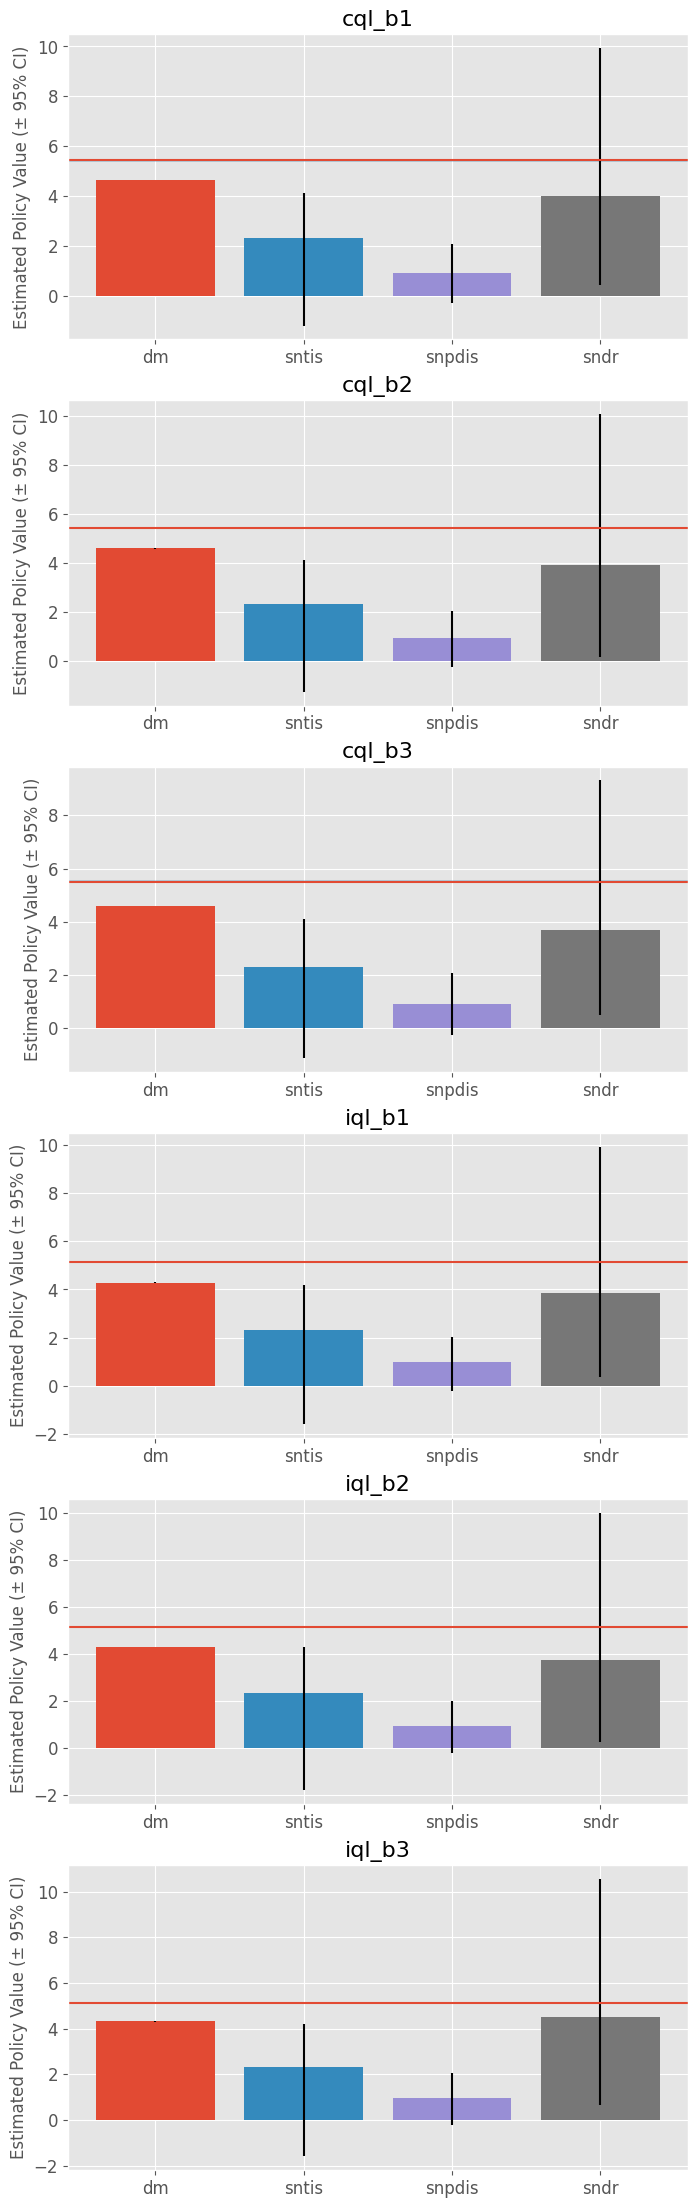

In [55]:
# opeの結果の比較・可視化
ope.visualize_off_policy_estimates(
    input_dict, 
    compared_estimators=["dm", "sntis", "snpdis", "sndr"],
    random_state=random_state, 
    sharey=False,
)

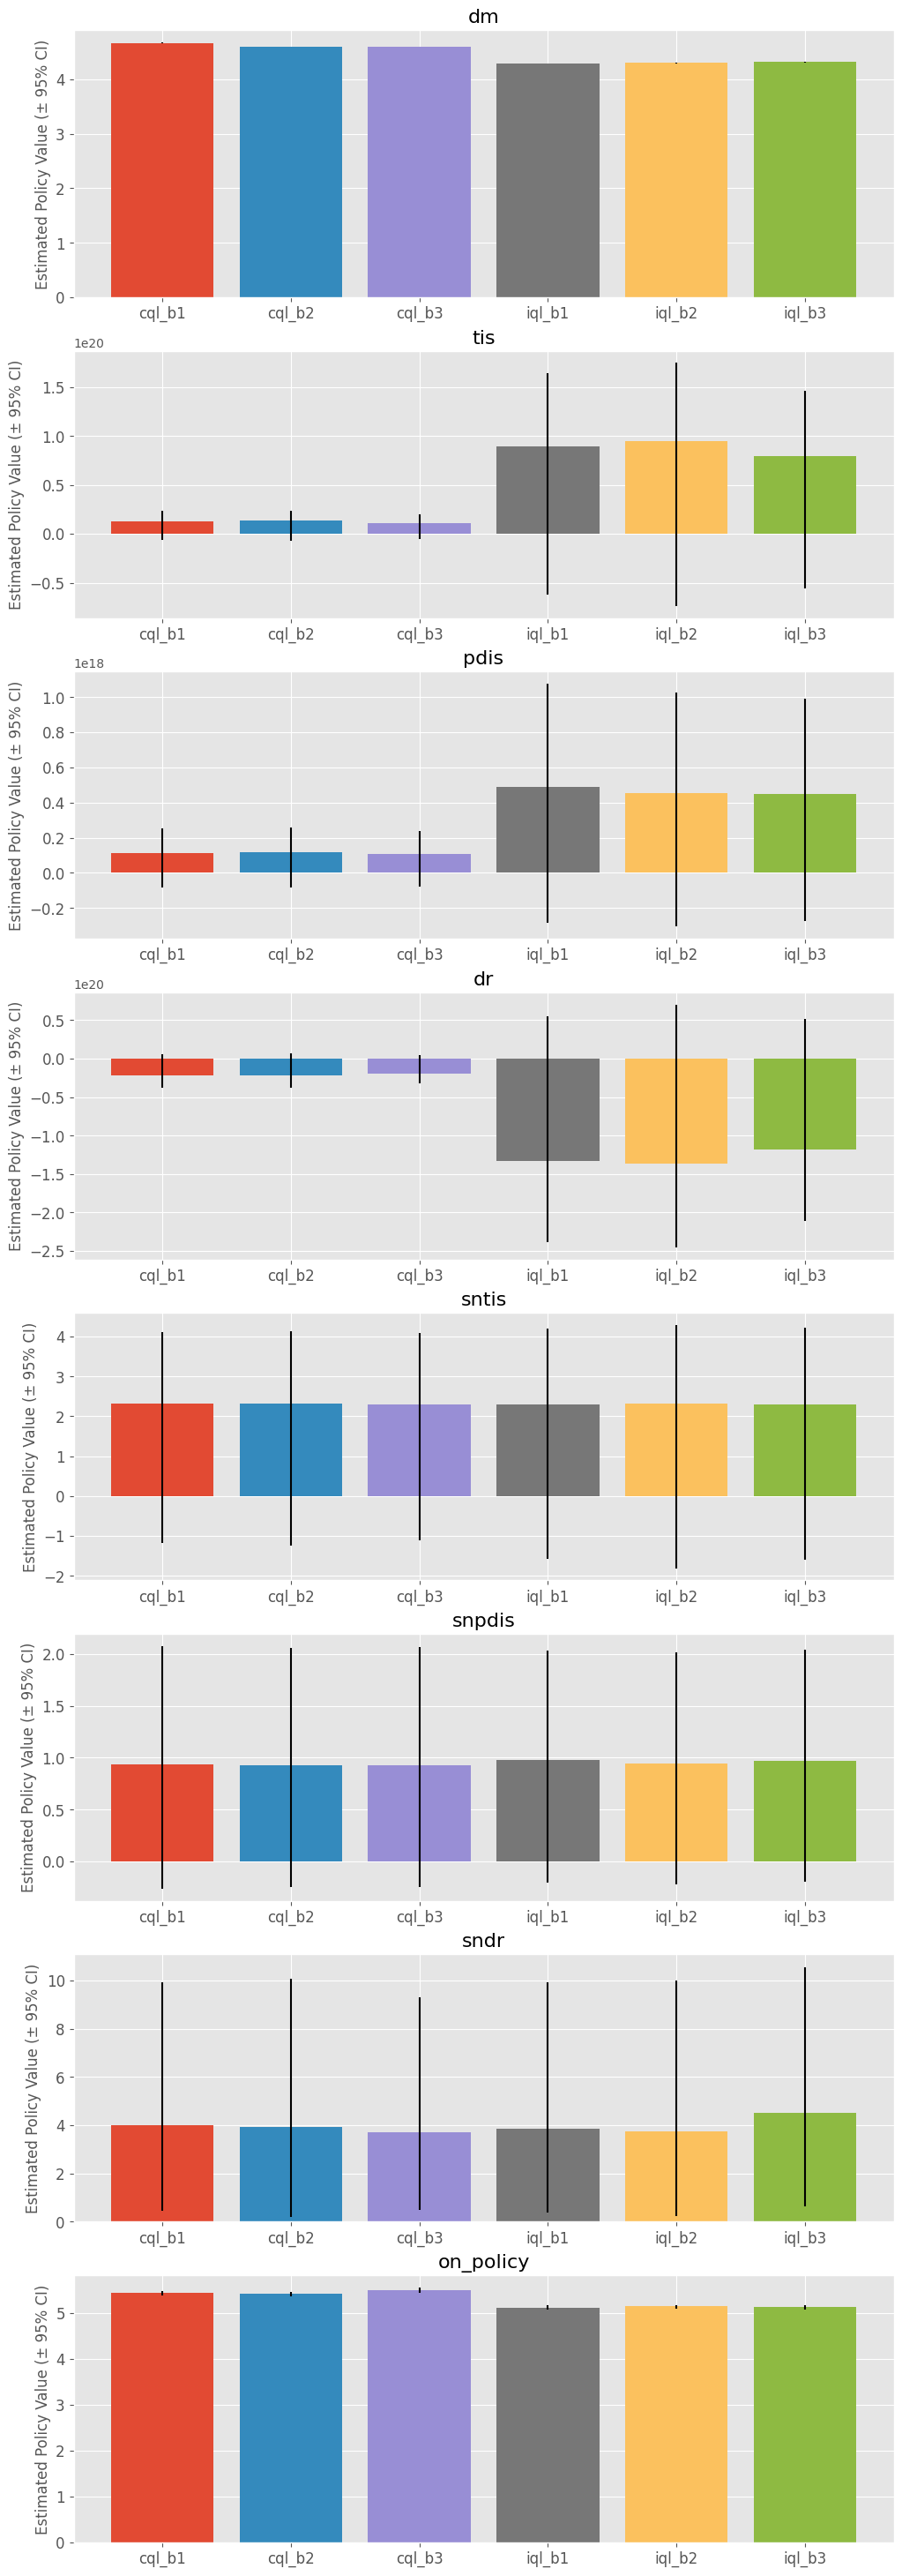

In [56]:
# OPE推定量の候補の方策価値を比較します
ope.visualize_off_policy_estimates(input_dict, random_state=random_state, hue="policy", sharey=False)

#### 累積分布関数推定
次に，軌跡単位での報酬の累積分布関数に基づき，方策性能に関する様々な統計量を推定します．

$$ F(t, \pi) := \mathbb{E}\left[ \mathbb{I} \left \{ \sum_{t=1}^T \gamma^{t-1} r_t \leq t \right \} \mid \pi \right] $$

特に，上記の累積度数分布から，以下の性能指標を推定することができます．
- 累積分布関数
- 期待値 (方策価値)
- 分散
- CVaR (Conditional Value at Risk)
- 四分位範囲

In [57]:
from scope_rl.ope import CumulativeDistributionOPE
from scope_rl.ope.continuous import CumulativeDistributionDM as CD_DM
from scope_rl.ope.continuous import CumulativeDistributionTIS as CD_IS
from scope_rl.ope.continuous import CumulativeDistributionTDR as CD_DR
from scope_rl.ope.continuous import CumulativeDistributionSNTIS as CD_SNIS
from scope_rl.ope.continuous import CumulativeDistributionSNTDR as CD_SNDR

In [58]:
cd_ope = CumulativeDistributionOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[
        CD_DM(estimator_name="cdf_dm"), 
        CD_IS(estimator_name="cdf_is"), 
        CD_DR(estimator_name="cdf_dr"), 
        CD_SNIS(estimator_name="cdf_snis"), 
        CD_SNDR(estimator_name="cdf_sndr"),
    ],
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  
        maximum=env.action_space.high, 
    ),
    bandwidth=1.0,
)

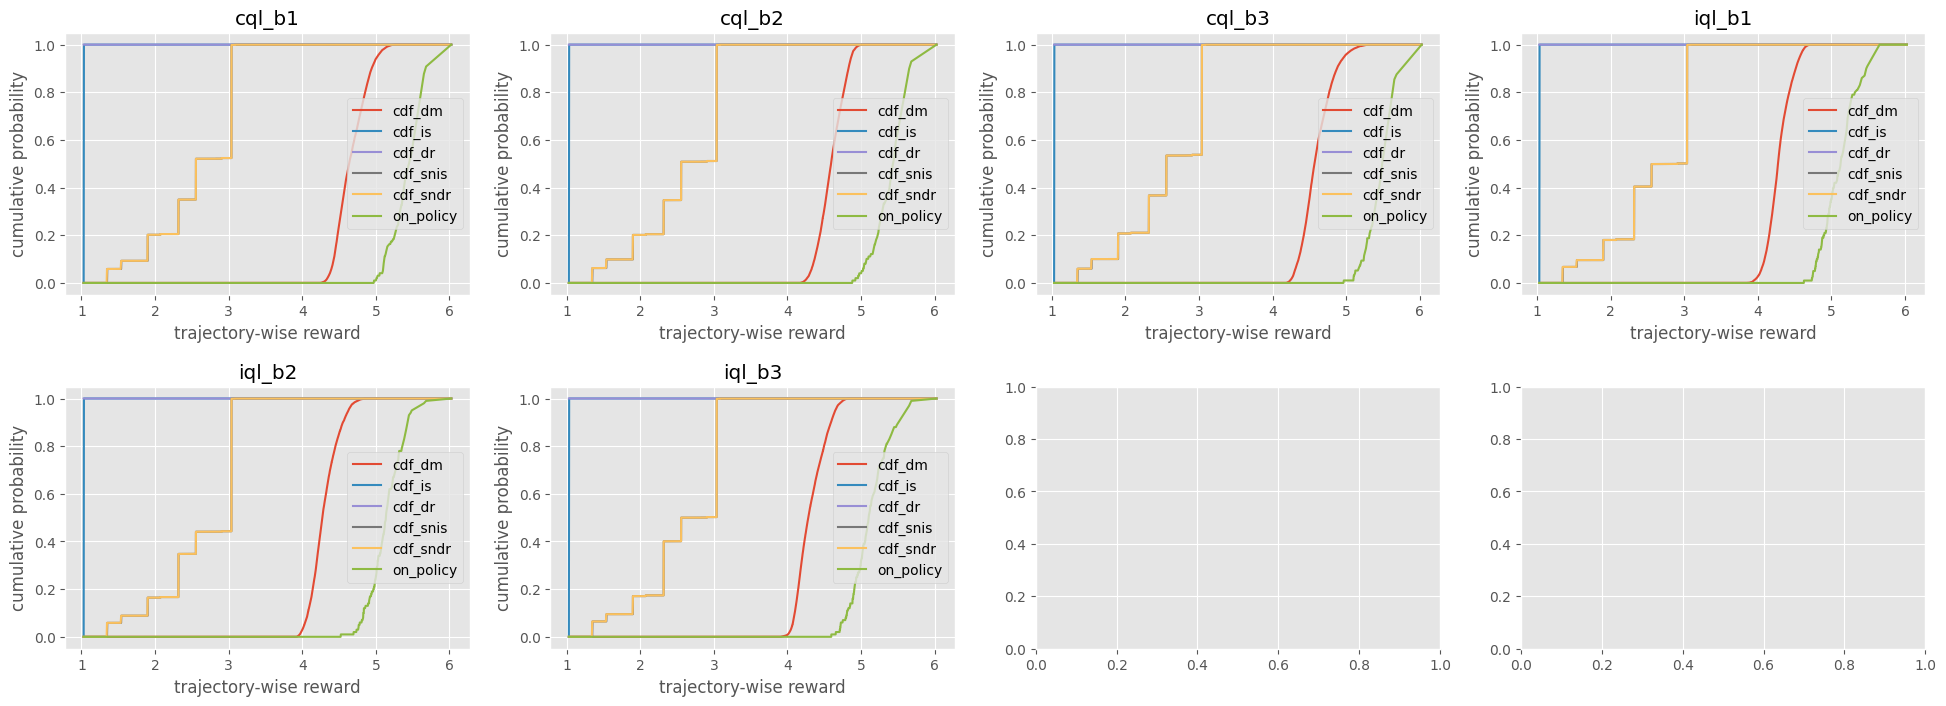

In [59]:
# 累積分布関数
cd_ope.visualize_cumulative_distribution_function(input_dict, n_cols=4)

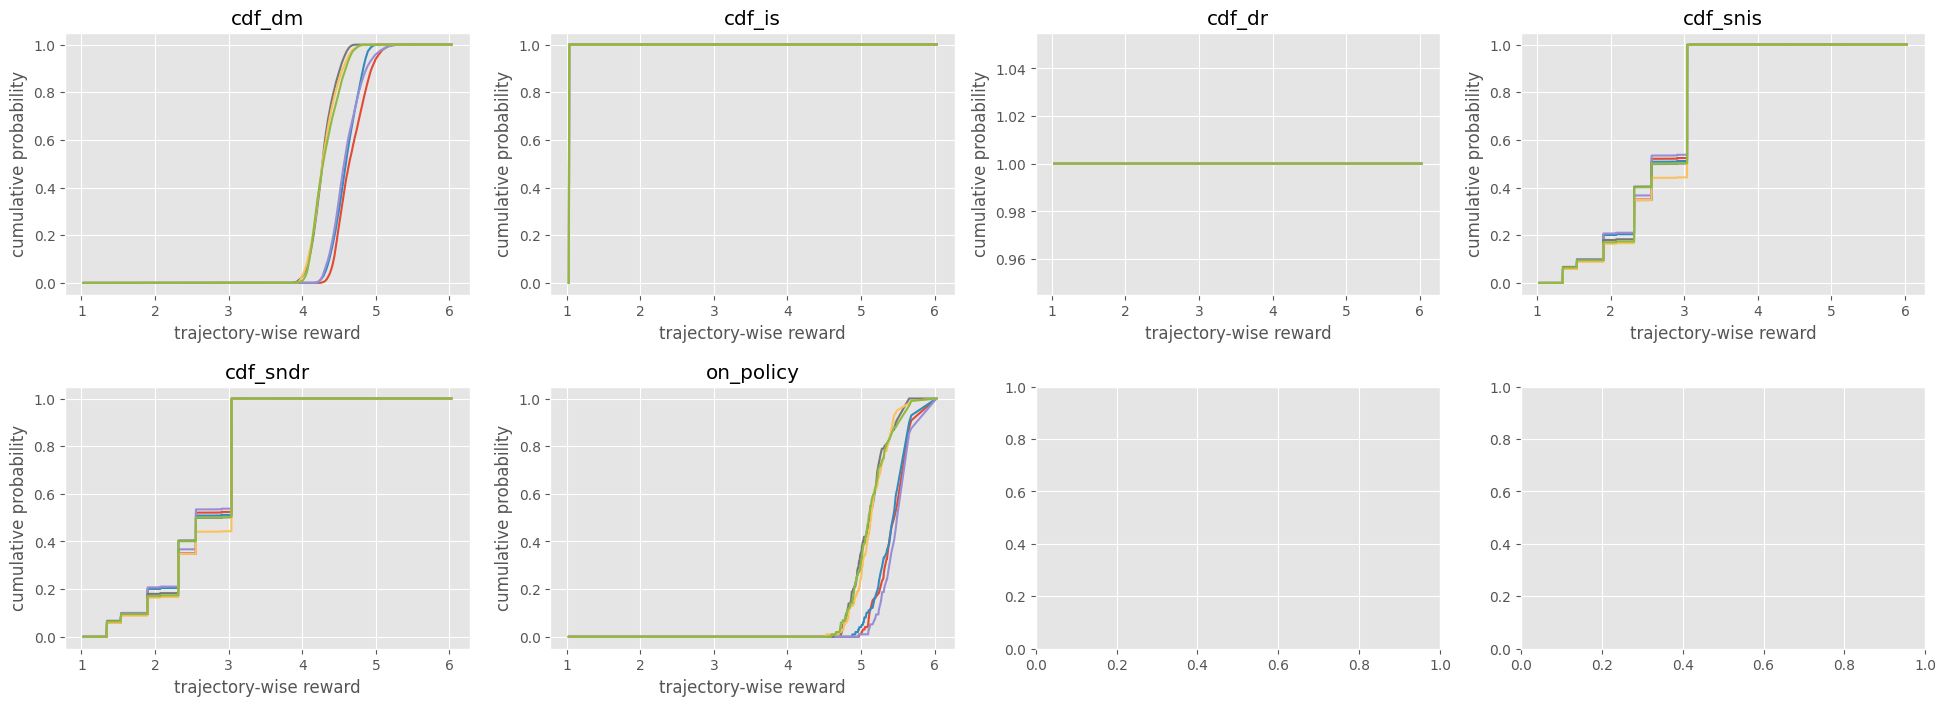

In [60]:
# それぞれのOPE推定量による累積分布関数の比較
# 凡例（評価方策の名前）は省略

cd_ope.visualize_cumulative_distribution_function(
    input_dict, 
    hue="policy",
    n_cols=4,
    legend=False,
)

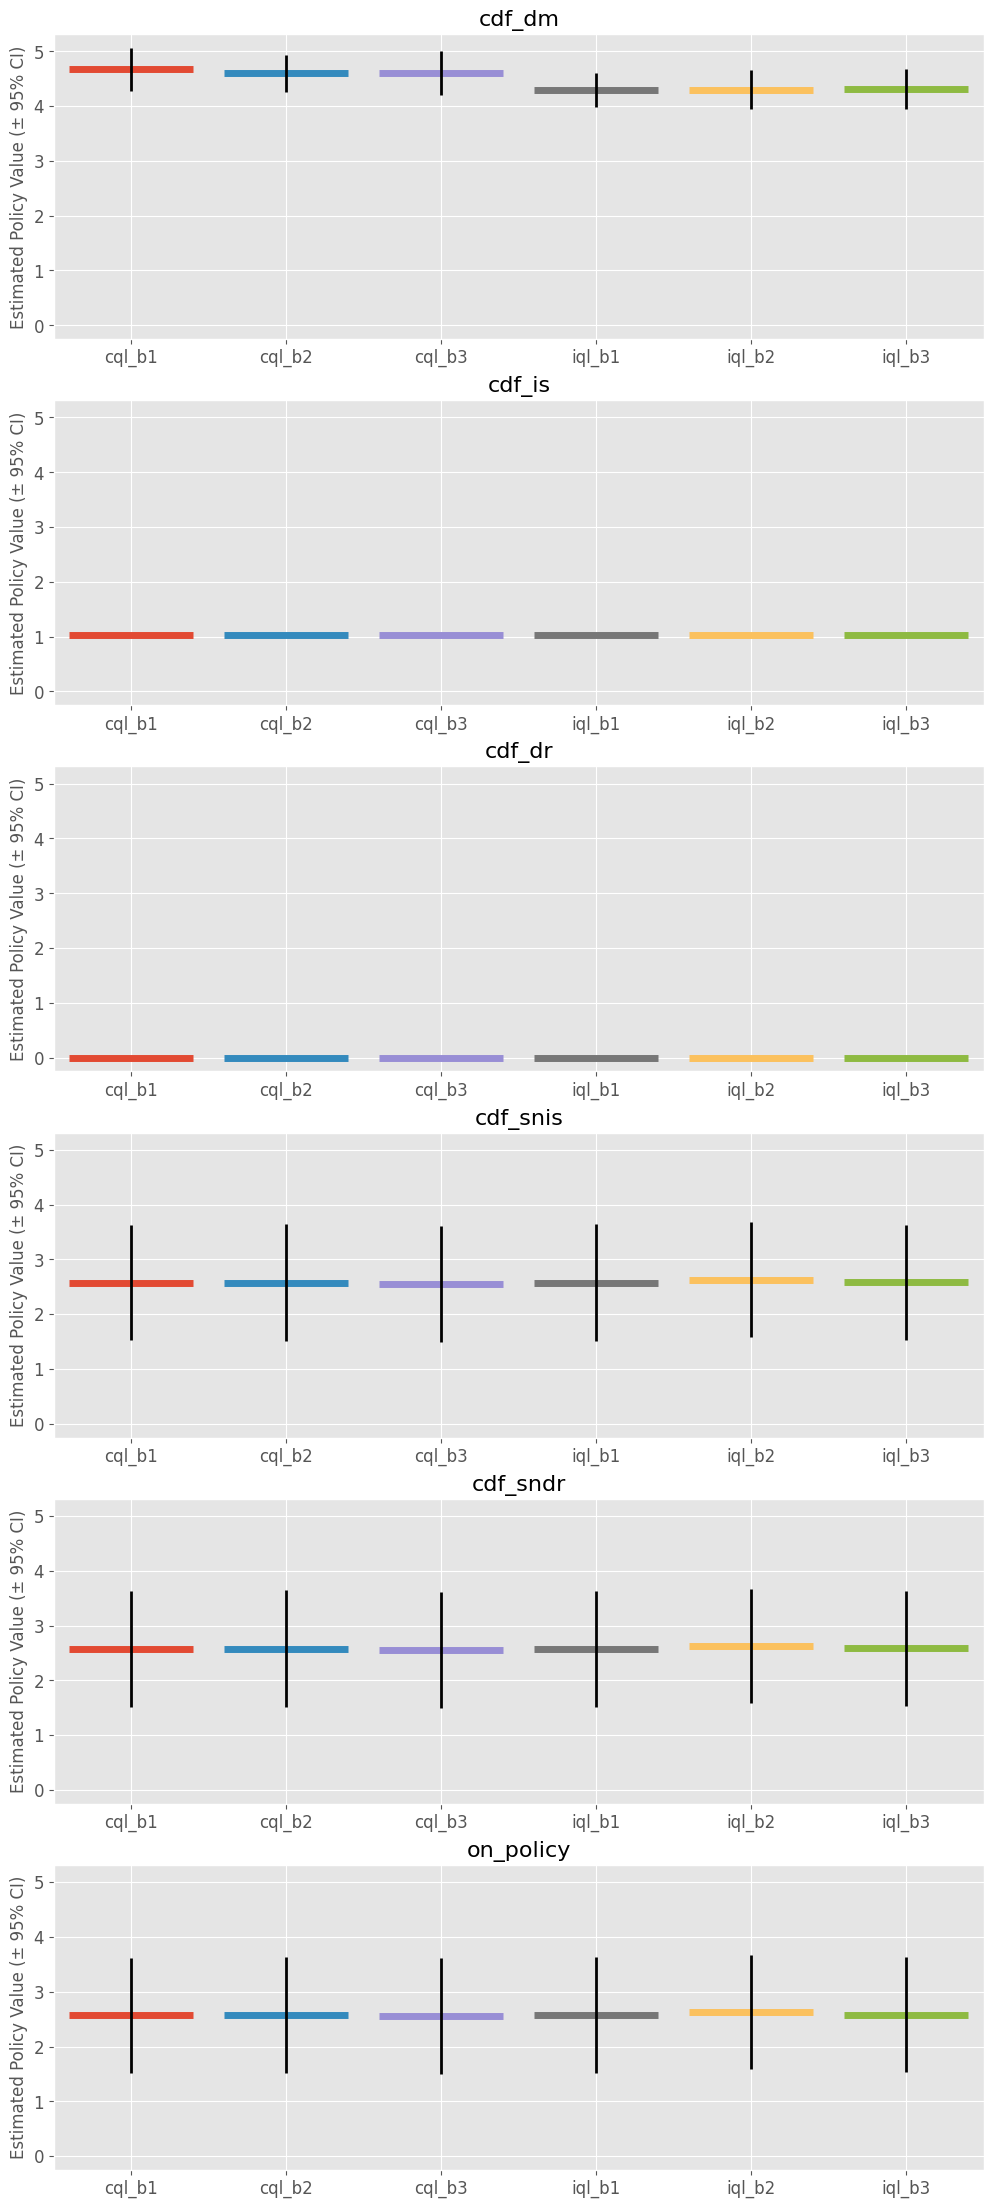

In [61]:
# 累積分布関数から求めた方策価値
mean_dict = cd_ope.estimate_mean(input_dict)
variance_dict = cd_ope.estimate_variance(input_dict)

# 平均と分散に基づく方策価値と信頼区間の可視化
# OPE推定量による候補方策間での比較
cd_ope.visualize_policy_value(input_dict, hue="policy", sharey=True)

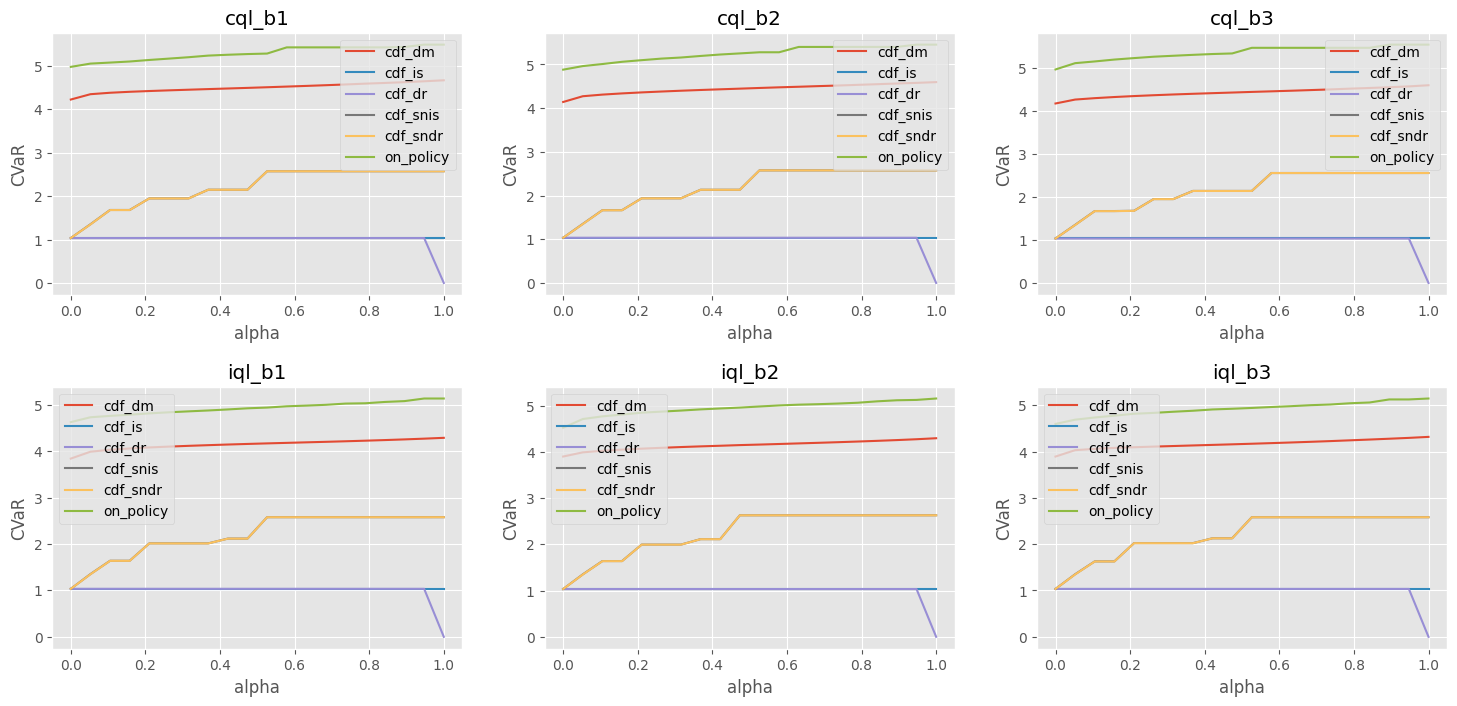

In [62]:
# conditional value at risk
cvar_dict = cd_ope.estimate_conditional_value_at_risk(input_dict, alphas=0.3)
# conditional value at riskの可視化
cd_ope.visualize_conditional_value_at_risk(input_dict, alphas=np.linspace(0, 1, 20), n_cols=3, sharey=True)

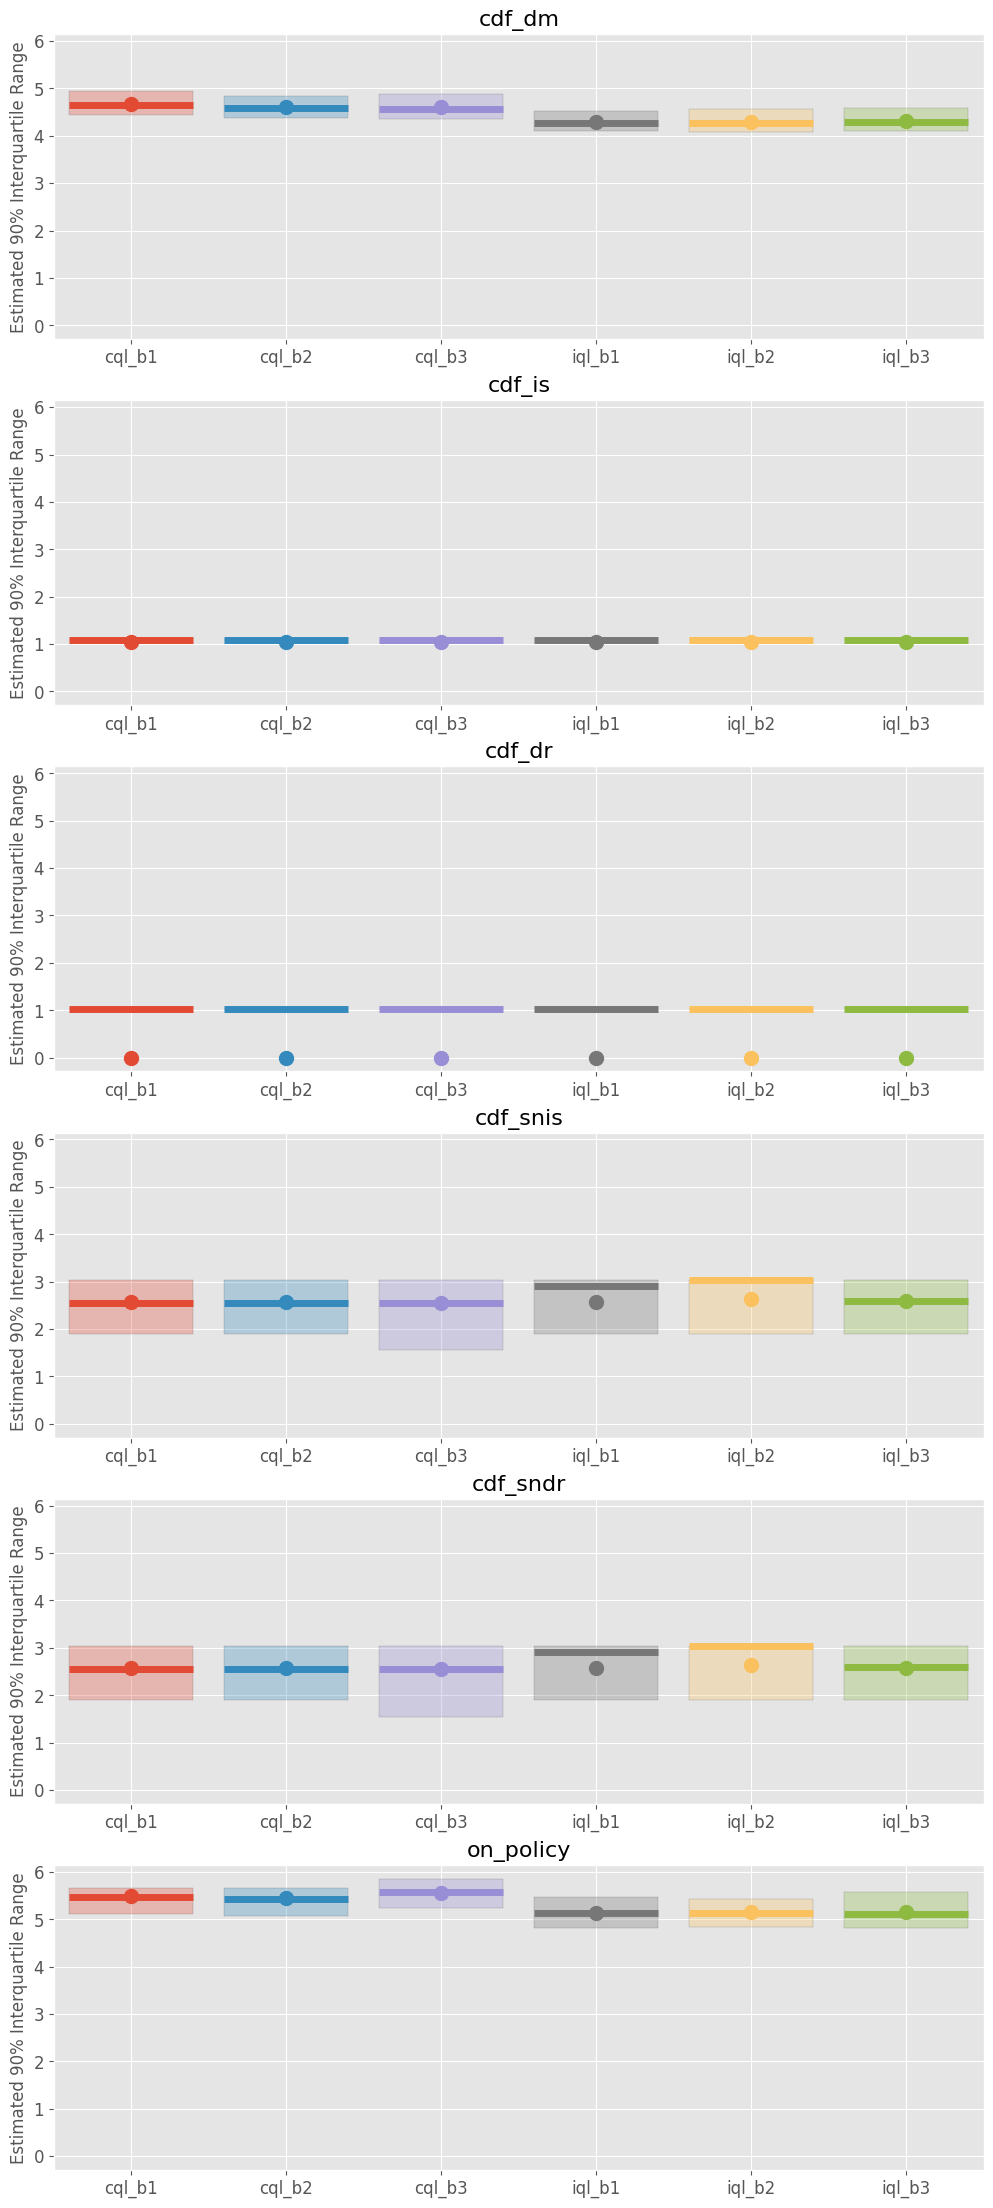

In [63]:
# 四分位範囲
interquartile_range_dict = cd_ope.estimate_interquartile_range(input_dict, alpha=0.10)
# 四分位範囲の可視化
cd_ope.visualize_interquartile_range(input_dict, alpha=0.10, hue="policy", sharey=True)

## 3. オフ方策選択

オフ方策選択の目的は，これまで推定してきた方策の性能指標に基づき，いくつかの候補方策の中から最も性能の良い方策を選択することです．これは，実際にどの方策を実環境にデプロイするか決定する手順に相当します．

In [64]:
from scope_rl.ope import OffPolicySelection

In [65]:
ops = OffPolicySelection(
    ope=ope,
    cumulative_distribution_ope=cd_ope,
)

In [66]:
ops.obtain_true_selection_result(
    input_dict=input_dict,
    return_variance=True,
    return_lower_quartile=True,
    return_conditional_value_at_risk=True,
    return_by_dataframe=True,
)

,ranking,policy_value,relative_policy_value,variance,ranking_by_lower_quartile,lower_quartile,ranking_by_conditional_value_at_risk,conditional_value_at_risk
0,cql_b3,5.503338,1.584076,0.050198,cql_b1,5.169706,cql_b3,5.078816
1,cql_b1,5.437971,1.565261,0.050118,cql_b2,5.097084,cql_b1,5.028852
2,cql_b2,5.414471,1.558497,0.054676,cql_b3,5.025414,cql_b2,4.948157
3,iql_b2,5.143979,1.480639,0.052177,iql_b1,4.778773,iql_b1,4.718639
4,iql_b3,5.127708,1.475955,0.062661,iql_b2,4.774412,iql_b2,4.696395
5,iql_b1,5.119494,1.473591,0.056606,iql_b3,4.722218,iql_b3,4.679068


In [67]:
ranking_df, metric_df = ops.select_by_policy_value(
    input_dict=input_dict,
    return_true_values=True,
    return_metrics=True,
    return_by_dataframe=True,
)

In [68]:
ranking_df

{'dm':   estimated_ranking  estimated_policy_value  estimated_relative_policy_value  \
 0            cql_b1                4.665842                         1.343012   
 1            cql_b3                4.597061                         1.323214   
 2            cql_b2                4.595770                         1.322843   
 3            iql_b3                4.315908                         1.242287   
 4            iql_b2                4.296344                         1.236656   
 5            iql_b1                4.286067                         1.233698   
 
    true_ranking  true_policy_value  true_relative_policy_value  
 0             1           5.437971                    1.565261  
 1             0           5.503338                    1.584076  
 2             2           5.414471                    1.558497  
 3             4           5.127708                    1.475955  
 4             3           5.143979                    1.480639  
 5             5           5.

In [69]:
metric_df

,estimator,mean_squared_error,rank_correlation,pvalue,regret@1,type_i_error_rate,type_ii_error_rate
0,dm,6.933167e-01,0.885714,0.018845,0.065367,0.0,0.0
1,tis,5.036704e+39,-0.828571,0.041563,0.359360,0.0,0.0
2,pdis,1.164921e+35,-0.942857,0.004805,0.383845,0.0,0.0
3,dr,1.049382e+40,0.828571,0.041563,0.000000,1.0,0.0
4,sntis,7.369676e+00,-0.771429,0.072397,0.359360,0.0,0.0
5,snpdis,1.888322e+01,-0.942857,0.004805,0.383845,0.0,0.0
6,sndr,2.683247e+00,-0.314286,0.544093,0.375630,0.0,0.0


In [70]:
ranking_df, metric_df = ops.select_by_policy_value_via_cumulative_distribution_ope(
    input_dict=input_dict,
    return_metrics=True,
    return_by_dataframe=True,
)

In [71]:
metric_df

,estimator,mean_squared_error,rank_correlation,pvalue,regret@1,type_i_error_rate,type_ii_error_rate
0,cdf_dm,0.692049,0.885714,0.018845,0.065367,0.0,0.0
1,cdf_is,18.153017,-1.000000,0.000000,0.383845,0.0,0.0
2,cdf_dr,28.022980,-1.000000,0.000000,0.383845,0.0,0.0
3,cdf_snis,7.366275,-0.771429,0.072397,0.359360,0.0,0.0
4,cdf_sndr,7.369676,-0.771429,0.072397,0.359360,0.0,0.0


In [72]:
ranking_df, metric_df = ops.select_by_policy_value_lower_bound(
    input_dict=input_dict,
    cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    return_metrics=True,
    return_by_dataframe=True,
    random_state=12345,
)

In [73]:
metric_df

,ci,estimator,mean_squared_error,rank_correlation,pvalue,regret@1,type_i_error_rate,type_ii_error_rate
0,bootstrap,dm,NaN,0.771429,0.072397,0.065367,0.000000,0.0
1,bootstrap,tis,NaN,-0.885714,0.018845,0.383845,0.000000,0.0
2,bootstrap,pdis,NaN,0.771429,0.072397,0.065367,1.000000,0.0
3,bootstrap,dr,NaN,0.828571,0.041563,0.000000,1.000000,0.0
4,bootstrap,sntis,NaN,0.714286,0.110787,0.065367,0.000000,0.0
5,bootstrap,snpdis,NaN,-0.942857,0.004805,0.383845,1.000000,0.0
6,bootstrap,sndr,NaN,0.085714,0.871743,0.375630,1.000000,0.0
7,bernstein,dm,NaN,0.885714,0.018845,0.065367,0.000000,0.0
8,bernstein,tis,NaN,0.828571,0.041563,0.000000,1.000000,0.0
9,bernstein,pdis,NaN,0.885714,0.018845,0.065367,1.000000,0.0


In [74]:
ranking_df, metric_df = ops.select_by_lower_quartile(
    input_dict=input_dict,
    return_metrics=True,
    return_by_dataframe=True,
)

In [75]:
metric_df

,estimator,mean_squared_error,rank_correlation,pvalue,regret,type_i_error_rate,type_ii_error_rate
0,cdf_dm,0.546124,0.828571,0.041563,NaN,0.0,0.0
1,cdf_is,14.812572,-1.000000,0.000000,NaN,0.0,0.0
2,cdf_dr,15.210973,-1.000000,0.000000,NaN,0.0,0.0
3,cdf_snis,12.816700,-1.000000,0.000000,NaN,0.0,0.0
4,cdf_sndr,12.838637,-1.000000,0.000000,NaN,0.0,0.0


In [76]:
ranking_df, metric_df = ops.select_by_conditional_value_at_risk(
    input_dict=input_dict,
    return_metrics=True,
    return_by_dataframe=True,
)

In [77]:
metric_df

,estimator,mean_squared_error,rank_correlation,pvalue,regret,type_i_error_rate,type_ii_error_rate
0,cdf_dm,0.509333,0.600000,0.208000,NaN,0.0,0.0
1,cdf_is,14.655400,-1.000000,0.000000,NaN,0.0,0.0
2,cdf_dr,14.655400,-1.000000,0.000000,NaN,0.0,0.0
3,cdf_snis,12.327493,-0.714286,0.110787,NaN,0.0,0.0
4,cdf_sndr,12.355930,-0.771429,0.072397,NaN,0.0,0.0


In [78]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    return_safety_violation_rate=True,
    relative_safety_criteria=1.0,
    return_by_dataframe=True,
)

In [79]:
topk_metric_df[:30]

,estimator,topk,k-th,best,worst,mean,std,safety_violation_rate,sharpe_ratio
0,dm,0,5.437971,5.437971,5.437971,5.437971,NaN,0.0,NaN
1,dm,1,5.503338,5.503338,5.437971,5.470655,0.046222,0.0,43.900852
2,dm,2,5.414471,5.503338,5.414471,5.451927,0.046048,0.0,44.066450
3,dm,3,5.127708,5.503338,5.127708,5.370872,0.166412,0.0,12.193671
4,dm,4,5.143979,5.503338,5.127708,5.325493,0.176255,0.0,11.512714
5,dm,5,5.119494,5.503338,5.119494,5.291160,0.178677,0.0,11.356687
0,tis,0,5.143979,5.143979,5.143979,5.143979,NaN,0.0,NaN
1,tis,1,5.119494,5.143979,5.119494,5.131736,0.017314,0.0,96.445270
2,tis,2,5.127708,5.143979,5.119494,5.130393,0.012461,0.0,133.998191
3,tis,3,5.414471,5.414471,5.119494,5.201413,0.142403,0.0,13.625502


In [80]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    return_safety_violation_rate=True,
    relative_safety_criteria=1.0,
    return_by_dataframe=True,
)

In [81]:
topk_metric_df.head()

,estimator,topk,k-th,best,worst,mean,std,safety_violation_rate,sharpe_ratio
0,cdf_dm,0,5.437971,5.437971,5.437971,5.437971,NaN,0.0,NaN
1,cdf_dm,1,5.503338,5.503338,5.437971,5.470655,0.046222,0.0,43.900852
2,cdf_dm,2,5.414471,5.503338,5.414471,5.451927,0.046048,0.0,44.066450
3,cdf_dm,3,5.127708,5.503338,5.127708,5.370872,0.166412,0.0,12.193671
4,cdf_dm,4,5.143979,5.503338,5.127708,5.325493,0.176255,0.0,11.512714


In [82]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    return_safety_violation_rate=True,
    relative_safety_criteria=1.0,
    return_by_dataframe=True,
    random_state=random_state,
)

In [83]:
topk_metric_df.head()

,ci,estimator,topk,k-th,best,worst,mean,std,safety_violation_rate,sharpe_ratio
0,bootstrap,dm,0,5.503338,5.503338,5.503338,5.503338,NaN,0.0,NaN
1,bootstrap,dm,1,5.437971,5.503338,5.437971,5.470655,0.046222,0.0,43.900852
2,bootstrap,dm,2,5.414471,5.503338,5.414471,5.451927,0.046048,0.0,44.066450
3,bootstrap,dm,3,5.119494,5.503338,5.119494,5.368819,0.170416,0.0,11.907198
4,bootstrap,dm,4,5.127708,5.503338,5.119494,5.320596,0.182779,0.0,11.101825


In [84]:
topk_metric_df = ops.obtain_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=7.0,
    return_by_dataframe=True,
)

In [85]:
topk_metric_df.head()

,estimator,topk,k-th,best,worst,mean,std,safety_violation_rate,sharpe_ratio
0,dm,0,5.066110,5.066110,5.066110,5.066110,NaN,1.0,NaN
1,dm,1,5.137575,5.137575,5.066110,5.101843,0.050533,1.0,55.654535
2,dm,2,4.998265,5.137575,4.998265,5.067317,0.069663,1.0,40.371600
3,dm,3,4.726272,5.137575,4.726272,4.982056,0.179759,1.0,15.645497
4,dm,4,4.754315,5.137575,4.726272,4.936507,0.186033,1.0,15.117867


In [86]:
topk_metric_df = ops.obtain_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=7.0,
    return_by_dataframe=True,
)

In [87]:
topk_metric_df.head()

,estimator,topk,k-th,best,worst,mean,std,safety_violation_rate,sharpe_ratio
0,cdf_dm,0,5.066110,5.066110,5.066110,5.066110,NaN,1.0,NaN
1,cdf_dm,1,4.998265,5.066110,4.998265,5.032187,0.047974,1.0,57.133919
2,cdf_dm,2,5.137575,5.137575,4.998265,5.067317,0.069663,1.0,40.371600
3,cdf_dm,3,4.726272,5.137575,4.726272,4.982056,0.179759,1.0,15.645497
4,cdf_dm,4,4.752008,5.137575,4.726272,4.936046,0.186599,1.0,15.071949


In [88]:
topk_metric_df = ops.obtain_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=10.0,
    return_by_dataframe=True,
)

In [89]:
topk_metric_df.head()

,estimator,topk,k-th,best,worst,mean,std,safety_violation_rate,sharpe_ratio
0,dm,0,5.237111,5.237111,5.237111,5.237111,NaN,1.0,NaN
1,dm,1,5.095118,5.237111,5.095118,5.166114,0.100404,1.0,25.616108
2,dm,2,5.114568,5.237111,5.095118,5.148932,0.076982,1.0,33.410086
3,dm,3,4.809485,5.237111,4.809485,5.064070,0.180989,1.0,14.210634
4,dm,4,4.810481,5.237111,4.809485,5.013352,0.193466,1.0,13.294114


In [90]:
topk_metric_df = ops.obtain_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=10.0,
    return_by_dataframe=True,
)

In [91]:
topk_metric_df.head()

,estimator,topk,k-th,best,worst,mean,std,safety_violation_rate,sharpe_ratio
0,cdf_dm,0,5.237111,5.237111,5.237111,5.237111,NaN,1.0,NaN
1,cdf_dm,1,5.114568,5.237111,5.114568,5.175839,0.086651,1.0,29.681904
2,cdf_dm,2,5.095118,5.237111,5.095118,5.148932,0.076982,1.0,33.410086
3,cdf_dm,3,4.809485,5.237111,4.809485,5.064070,0.180989,1.0,14.210634
4,cdf_dm,4,4.835576,5.237111,4.809485,5.018371,0.187108,1.0,13.745836


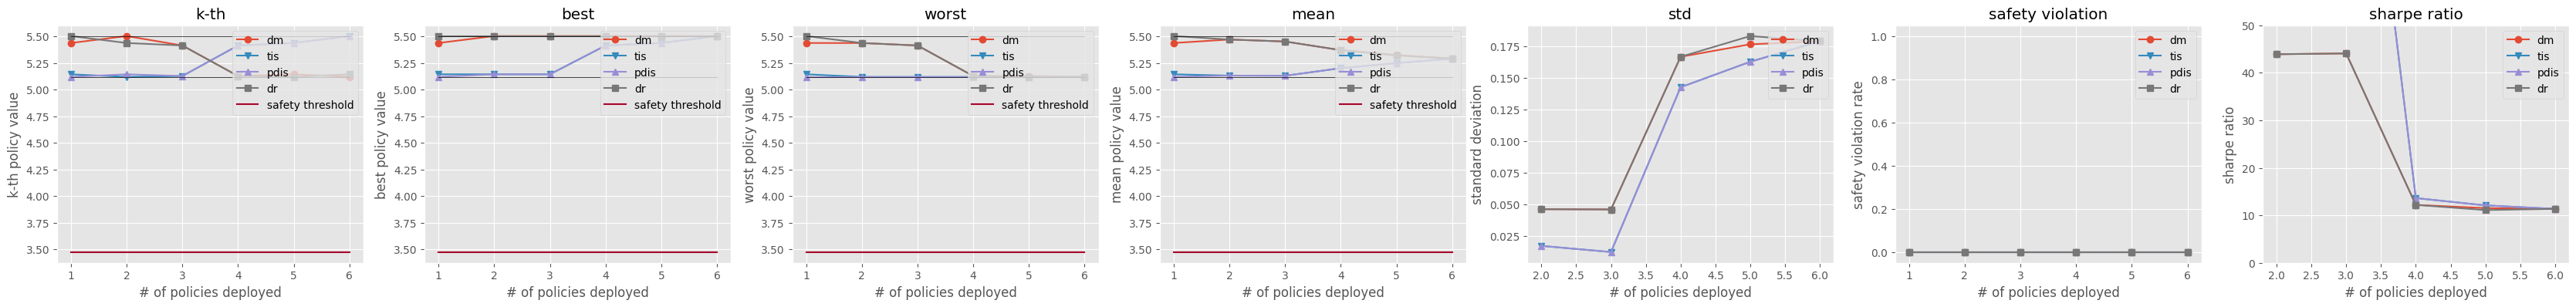

In [92]:
ops.visualize_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    relative_safety_criteria=1.0,
    ymax_sharpe_ratio=50.0,
    legend=True,
)

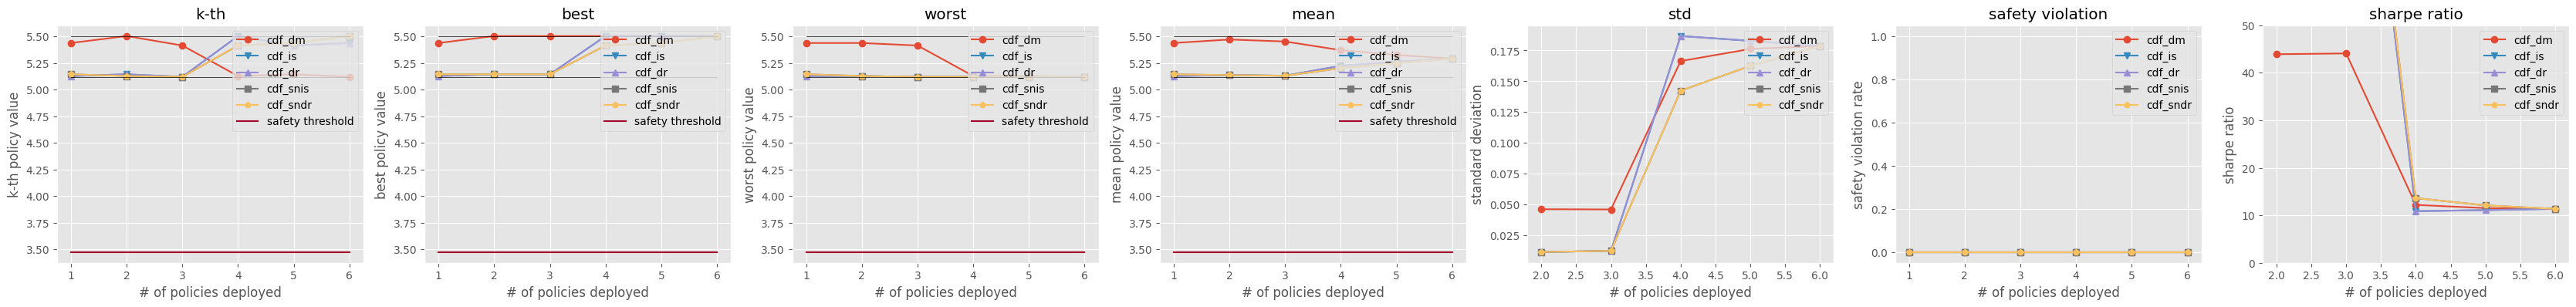

In [93]:
ops.visualize_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    relative_safety_criteria=1.0,
    ymax_sharpe_ratio=50.0,
    legend=True,
)

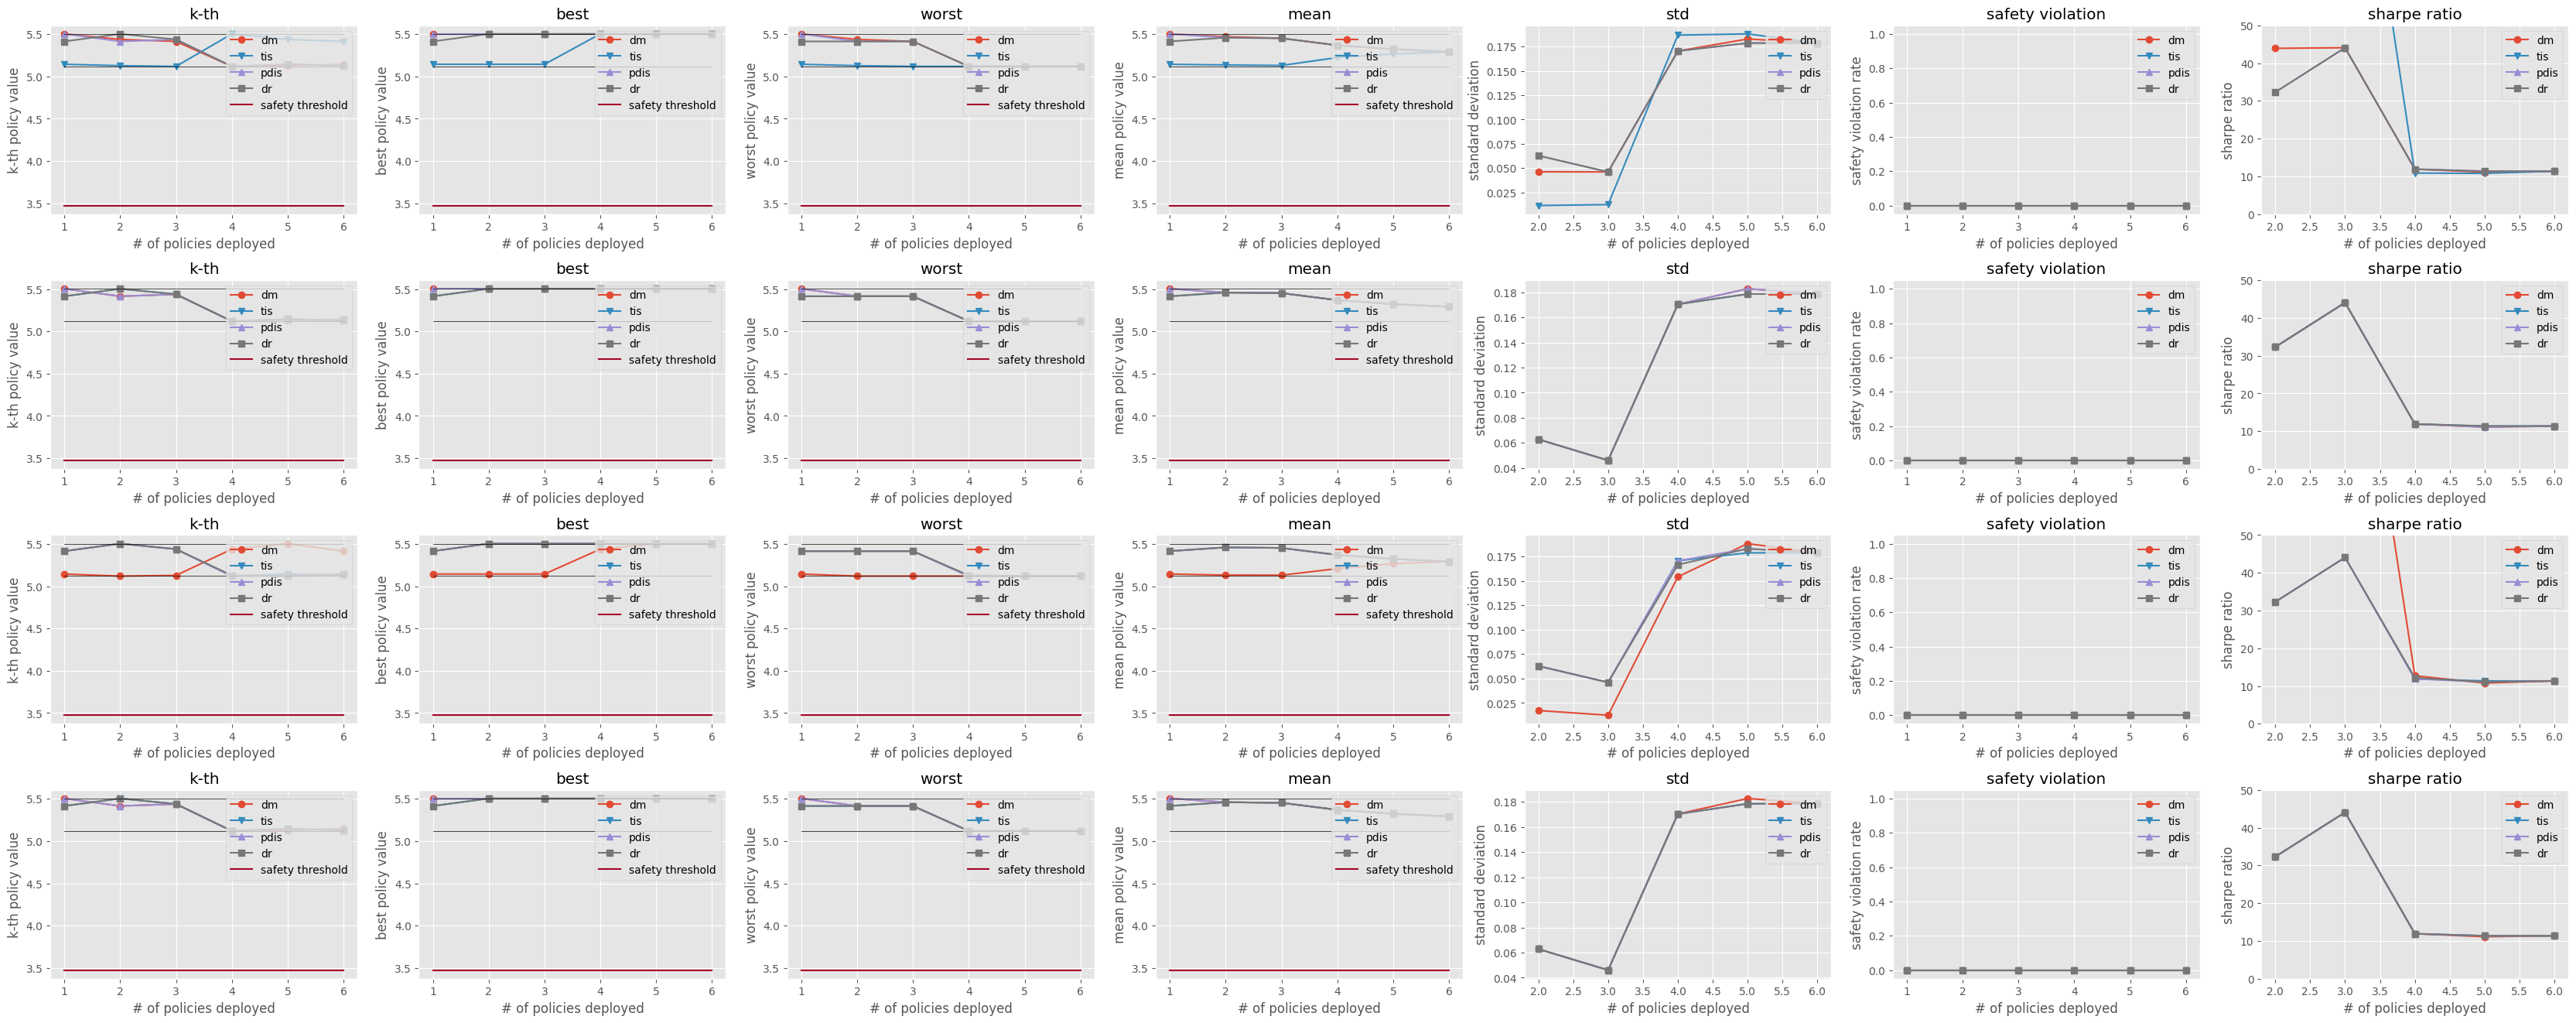

In [94]:
ops.visualize_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    relative_safety_criteria=1.0,
    ymax_sharpe_ratio=50.0,
    legend=True,
    random_state=12345,
)

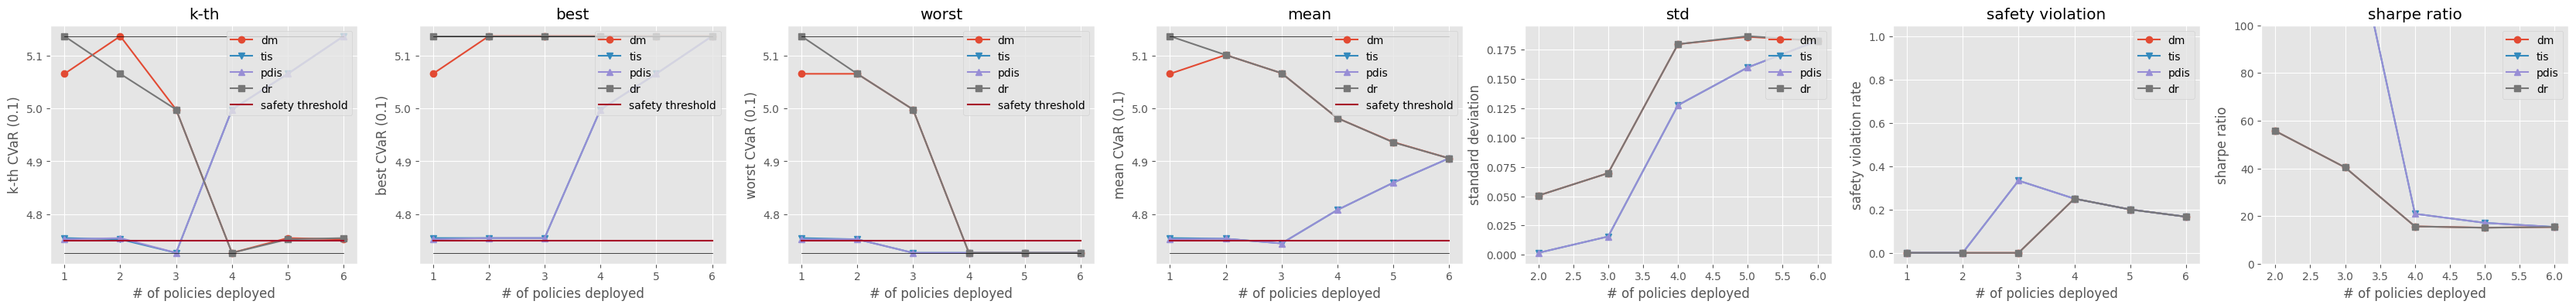

In [95]:
ops.visualize_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.10,
    safety_threshold=4.75,
    ymax_sharpe_ratio=100.0,
    legend=True,
)

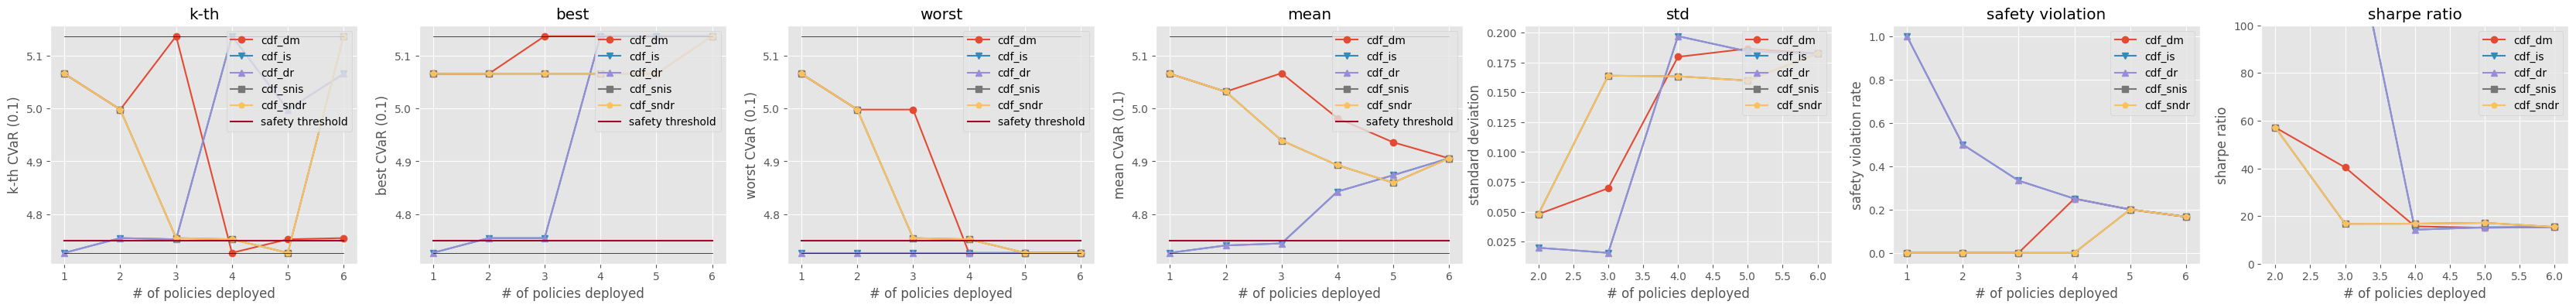

In [96]:
ops.visualize_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.10,
    safety_threshold=4.75,
    ymax_sharpe_ratio=100.0,
    legend=True,
)

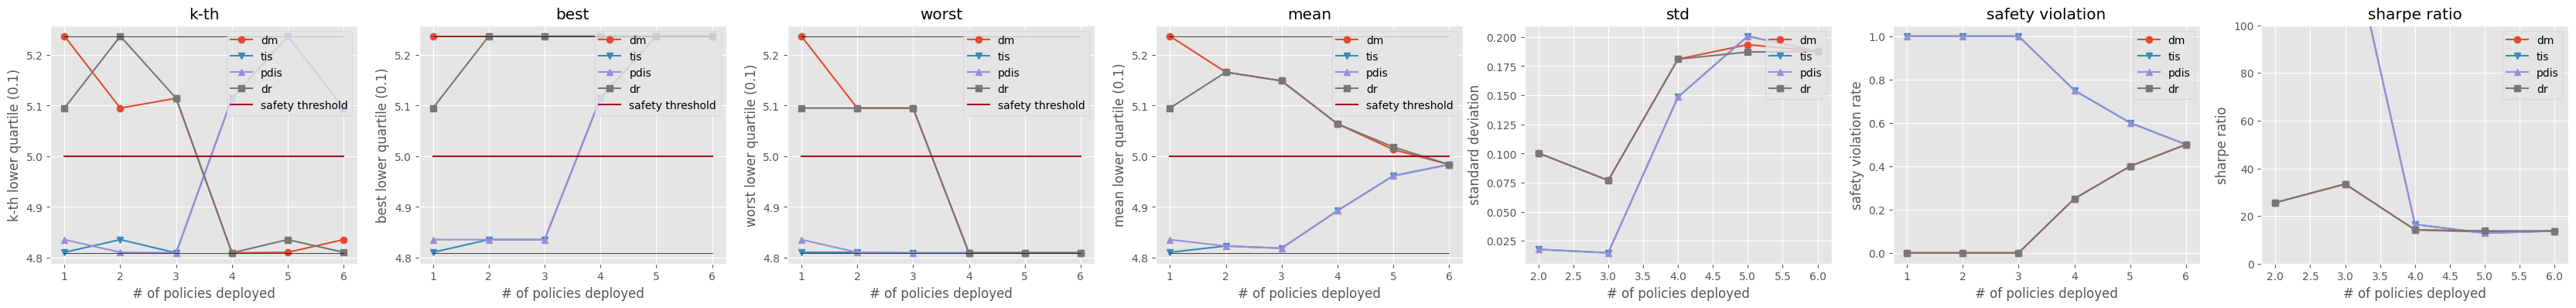

In [97]:
ops.visualize_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.10,
    safety_threshold=5.0,
    ymax_sharpe_ratio=100.0,
    legend=True,
)

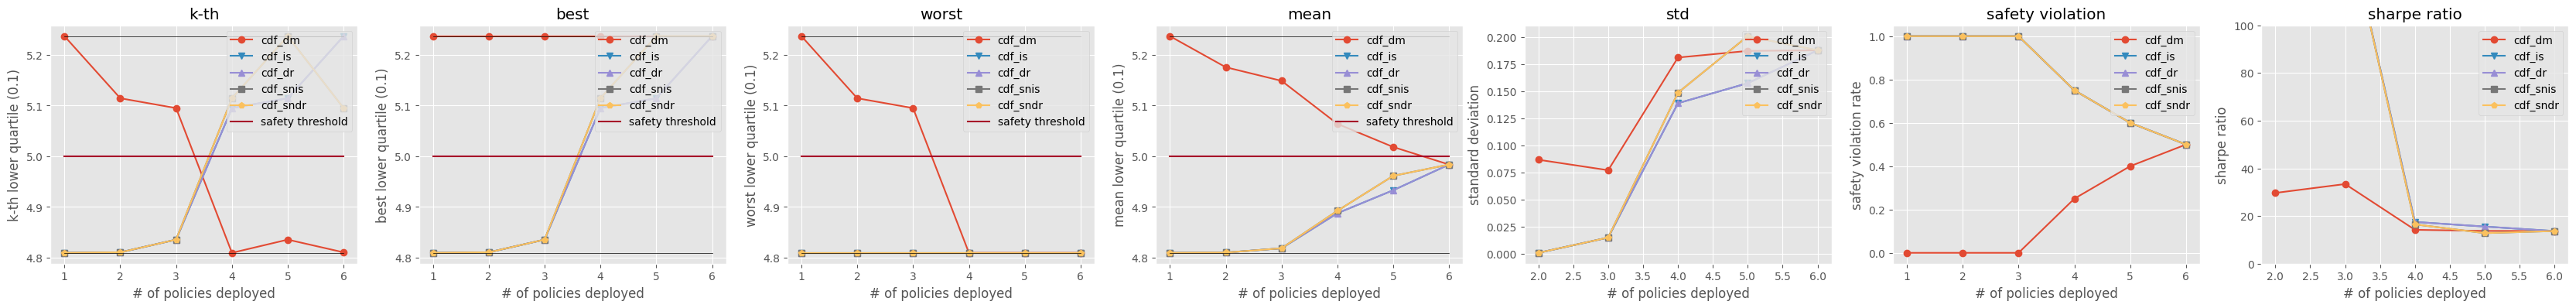

In [98]:
ops.visualize_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.10,
    safety_threshold=5.0,
    ymax_sharpe_ratio=100.0,
    legend=True,
)

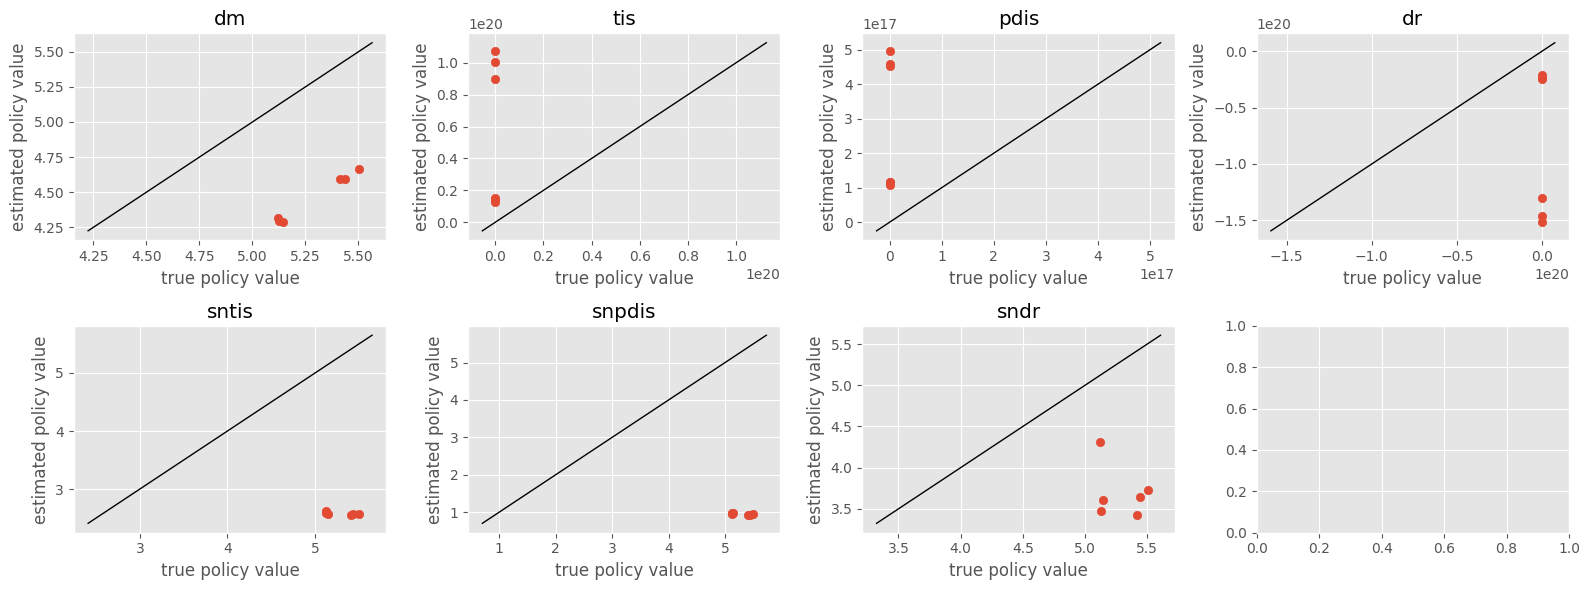

In [99]:
ops.visualize_policy_value_for_validation(
    input_dict=input_dict,
    n_cols=4,
)

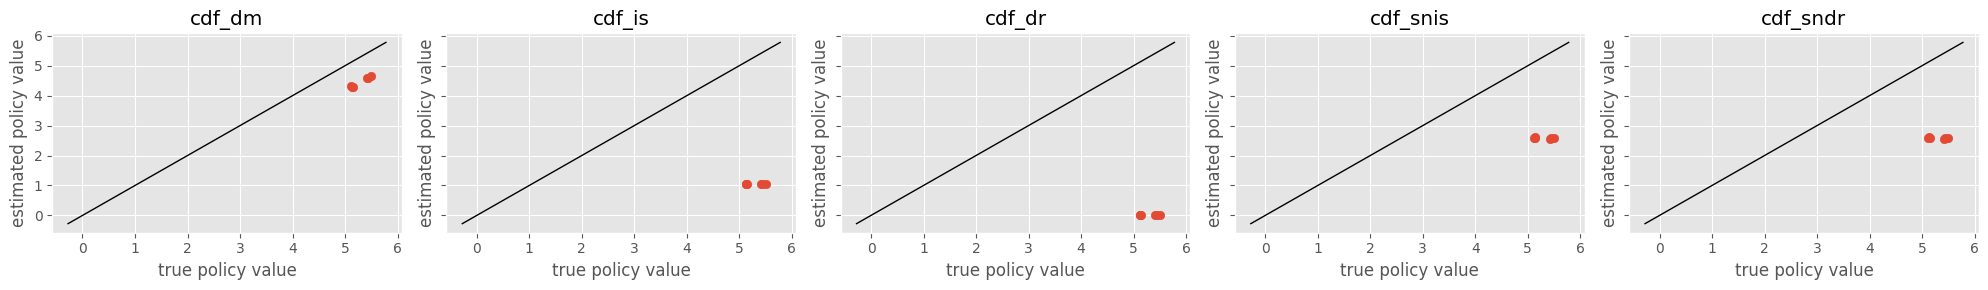

In [100]:
ops.visualize_policy_value_of_cumulative_distribution_ope_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

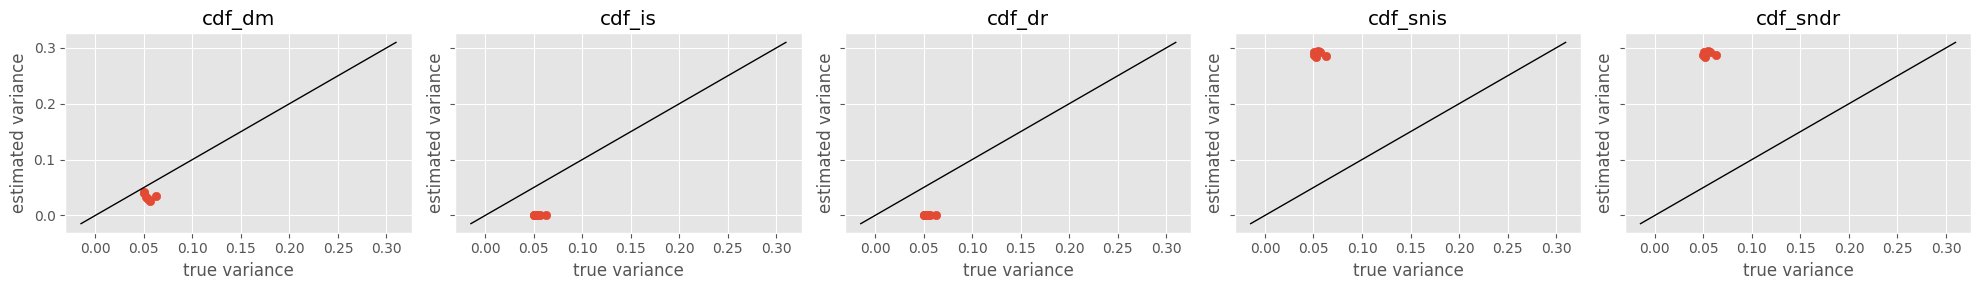

In [101]:
ops.visualize_variance_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

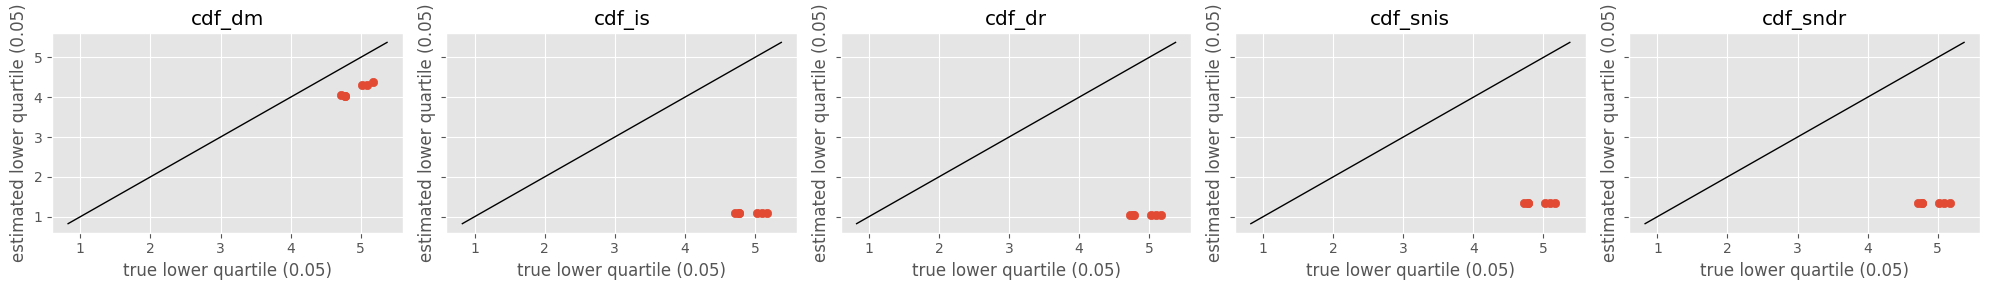

In [102]:
ops.visualize_lower_quartile_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

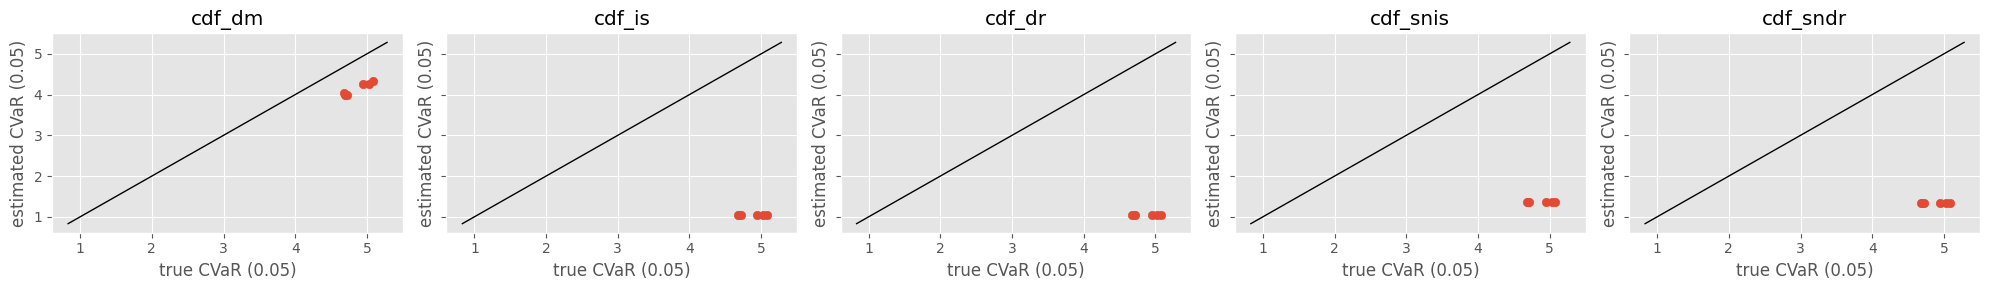

In [103]:
ops.visualize_conditional_value_at_risk_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

複数のデータセットでOPE/OPSを行う方法は
[examples/quickstart_ja/basic/basic_synthetic_continuous_multiple_datasets_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/basic/basic_synthetic_continuous_multiple_datasets_ja.ipynb)を参照してください．

離散的な行動空間に対する例は [examples/quickstart_ja/basic/basic_synthetic_discrete_advanced_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/basic/basic_synthetic_discrete_advanced_ja.ipynb)を参照してください．

## 参考文献

- Vladislav Kurenkov and Sergey Kolesnikov. \
"Showing Your Offline Reinforcement Learning Work: Online Evaluation Budget Matters.", 2022.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment for Markov Decision Processes.", 2022.

- Haanvid Lee, Jongmin Lee, Yunseon Choi, Wonseok Jeon, Byung-Jun Lee, Yung-Kyun Noh, and Kee-Eung Kim. \
"Local Metric Learning for Off-Policy Evaluation in Contextual Bandits with Continuous Actions.", 2022.

- Ilya Kostrikov, Ashvin Nair, and Sergey Levine. \
"Offline Reinforcement Learning with Implicit Q-Learning.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Shengpu Tang and Jenna Wiens. \
"Model Selection for Offline Reinforcement Learning: Practical Considerations for Healthcare Settings.", 2021.

- Justin Fu, Mohammad Norouzi, Ofir Nachum, George Tucker, Ziyu Wang, Alexander Novikov, Mengjiao Yang, Michael R. Zhang, Yutian Chen, Aviral Kumar, Cosmin Paduraru, Sergey Levine, and Tom Le Paine. \
"Benchmarks for Deep Off-Policy Evaluation.", 2021.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment in Contextual Bandits.", 2021.

- Yash Chandak, Scott Niekum, Bruno Castro da Silva, Erik Learned-Miller, Emma Brunskill, and Philip S. Thomas. \
"Universal Off-Policy Evaluation.", 2021.

- Scott Fujimoto and Shixiang Shane Gu. \
"A Minimalist Approach to Offline Reinforcement Learning.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Tom Le Paine, Cosmin Paduraru, Andrea Michi, Caglar Gulcehre, Konrad Zolna, Alexander Novikov, Ziyu Wang, and Nando de Freitas. \
"Hyperparameter Selection for Offline Reinforcement Learning.", 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Angela Zhou. \
"Policy Evaluation and Optimization with Continuous Treatments.", 2019.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Josiah P. Hanna, Peter Stone, and Scott Niekum. \
"Bootstrapping with Models: Confidence Intervals for Off-Policy Evaluation.", 2017.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Policy Improvement.", 2015.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Off-Policy Evaluation.", 2015.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.